In [16]:
import sys
from pathlib import Path
import pandas as pd
from traffic.core import Flight, Traffic
import matplotlib.pyplot as plt

sys.path.append("../")
from utils.data_loader import DataLoader
from preprocessing.airport_preprocessor import AirportPreprocessor

In [17]:
ld = DataLoader(Path("/home/wues_ni/Projects/ATOW-Prediction/data"))
challenge, _, _ = ld.load()
preprocessors = []

ds = challenge
for p in preprocessors:
    ds = p.apply(ds)

In [18]:
t = Traffic.from_file("/home/wues_ni/Projects/ATOW-Prediction/data/2022-01-01.parquet")
t

,count
flight_id,
248763716,29635
248762188,26719
248757757,26505
248765179,26217
248766045,26147
248757924,25816
248753995,24354
248763304,24286
248760278,23344


In [19]:
flight_id = t.data.flight_id.sample(1).iloc[0]
flight_info = ds.df[ds.df["flight_id"] == flight_id]

In [20]:
f = t.query(f"flight_id == {flight_id}")[0]
f.data.sort_values(by="timestamp", inplace=True)
f = f.filter(altitude=(17, 53))
f.data.rename({"u_component_of_wind": "wind_u", "v_component_of_wind": "wind_v"}, axis=1, inplace=True)
f = f.compute_TAS()

In [21]:
obt = pd.to_datetime(flight_info["actual_offblock_time"].iloc[0])
taxiout_mins = pd.to_timedelta(flight_info["taxiout_time"].iloc[0], unit="m")
arrival_time = pd.to_datetime(flight_info["arrival_time"].iloc[0])

includes_taxi = f.between(obt - pd.Timedelta(minutes=5), obt+taxiout_mins)
includes_takeoff = f.between(obt + taxiout_mins - pd.Timedelta(minutes=2), obt + taxiout_mins + pd.Timedelta(minutes=5))
inlcudes_inflight = f.between(obt + taxiout_mins, arrival_time)
includes_approach = f.between(arrival_time - pd.Timedelta(minutes=10), arrival_time - pd.Timedelta(minutes=2))
includes_arrival = f.between(arrival_time - pd.Timedelta(minutes=5), arrival_time + pd.Timedelta(minutes=5))

<Axes: >

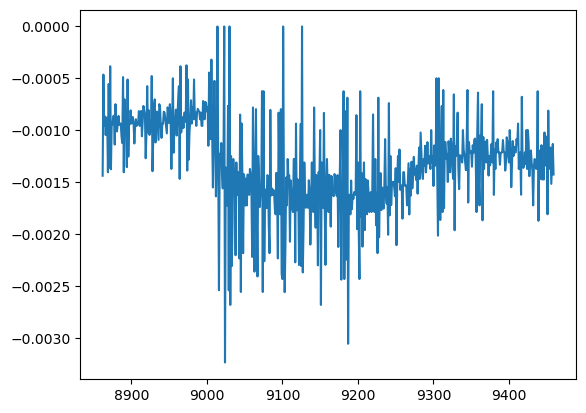

In [22]:
includes_arrival.data["longitude"].diff().plot()

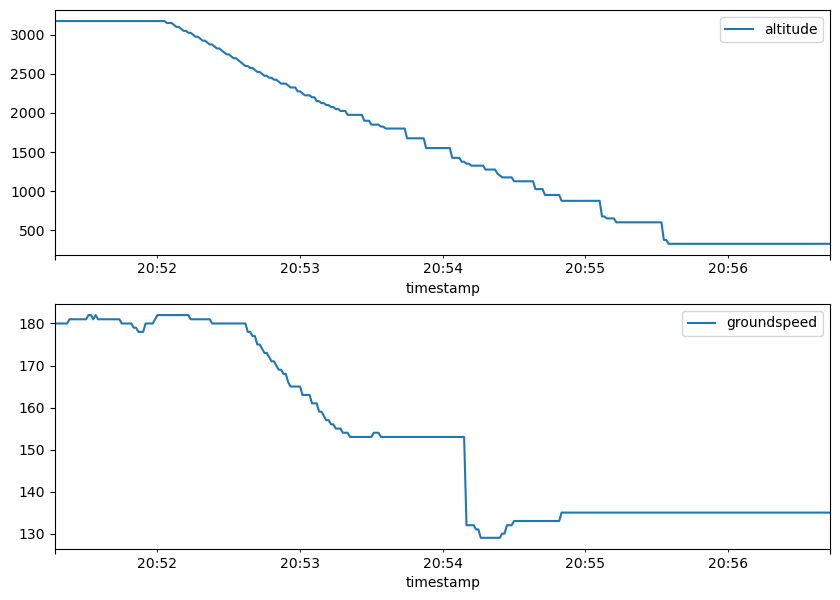

In [23]:
ap = f.landing_airport()
landing_profile = f.aligned_on_ils(ap.icao)
if landing_profile:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    landing_profile[0].plot_time(ax=ax1, y="altitude")
    landing_profile[0].plot_time(ax=ax2, y="groundspeed")
    plt.show()

In [24]:
# f.aligned_on_ils(ap.icao)[0].map_leaflet()

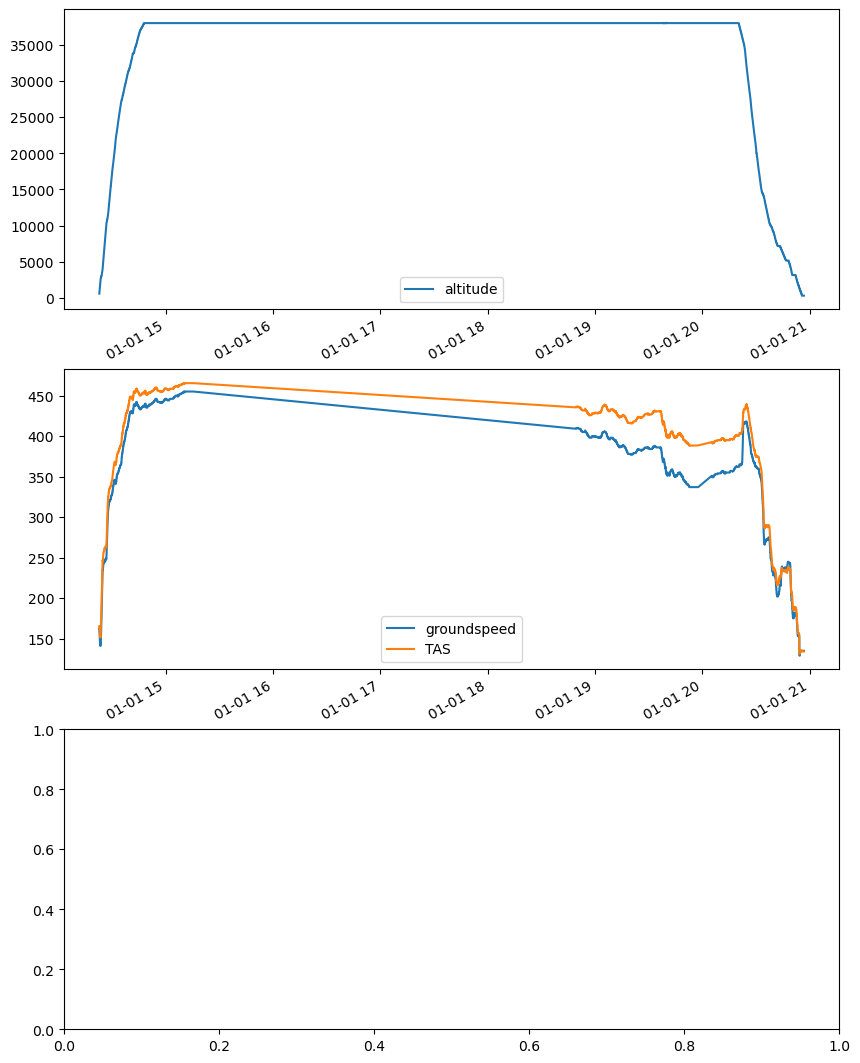

In [25]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

f.plot_time(ax=ax1, y="altitude")
f.plot_time(ax=ax2, y="groundspeed")
f.plot_time(ax=ax2, y="TAS")

plt.show()

In [26]:
f.map_leaflet()

Map(center=[48.38448631723438, -49.25679399542814], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [27]:
ap = f.takeoff_airport()
f.on_runway(ap.icao).map_leaflet()

Map(center=[53.42235671221199, -6.287938581194203], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [28]:
to = f.takeoff_from_runway(ap.icao)[0]
to.map_leaflet()

Map(center=[53.42341596825231, -6.304340761594235], controls=(ZoomControl(options=['position', 'zoom_in_text',…

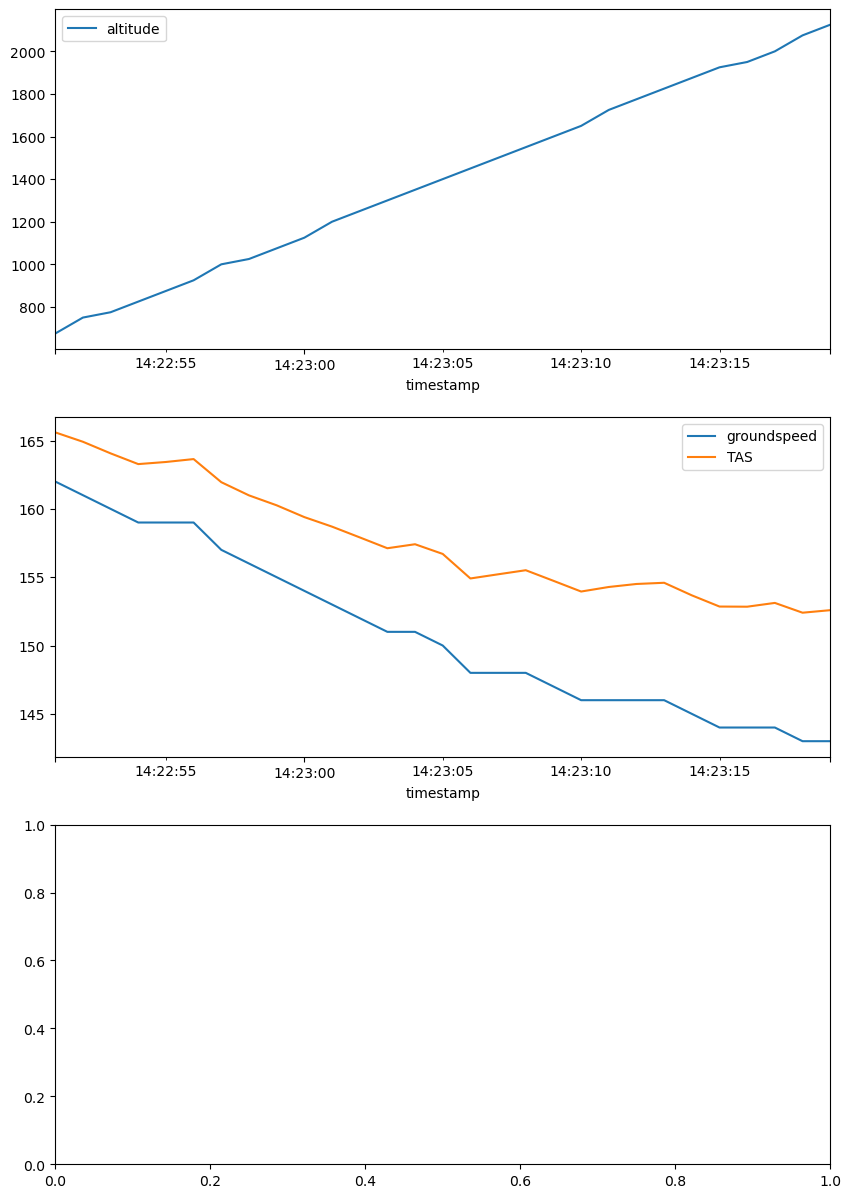

In [29]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

to.plot_time(ax=ax1, y="altitude")
to.plot_time(ax=ax2, y="groundspeed")
to.plot_time(ax=ax2, y="TAS")

plt.show()

In [30]:
runway_altitude = to.data.altitude.mode().values[0]

In [31]:
pd.set_option("display.max_rows", 100)
to.data[to.data["altitude"] >= runway_altitude]

,flight_id,timestamp,latitude,longitude,altitude,groundspeed,track,vertical_rate,wind_u,wind_v,temperature,specific_humidity,icao24,TAS,heading,phase,cumdist,compute_gs,compute_track,runway
2,248752196,2022-01-01 14:22:51+00:00,53.422348,-6.287868,675.0,162.0,276.027530,2624.0,4.245694,7.991200,285.500326,0.006596,248752196,165.595918,273.122382,CLIMB,0.089447,153.769678,275.701245,28L
3,248752196,2022-01-01 14:22:52+00:00,53.422464,-6.289511,750.0,161.0,276.064922,2816.0,4.587078,8.435129,285.325413,0.006580,248752196,164.909044,272.980761,CLIMB,0.148844,213.830755,276.717381,28L
4,248752196,2022-01-01 14:22:53+00:00,53.422510,-6.290238,775.0,160.0,275.782392,2816.0,4.700452,8.582284,285.267130,0.006574,248752196,164.059583,272.633412,CLIMB,0.175091,94.490845,276.118627,28L
5,248752196,2022-01-01 14:22:54+00:00,53.422577,-6.291556,825.0,159.0,275.782392,2816.0,4.927199,8.877377,285.150732,0.006564,248752196,163.274439,272.507036,CLIMB,0.222569,170.918193,274.845307,28L
6,248752196,2022-01-01 14:22:55+00:00,53.422650,-6.292743,875.0,159.0,276.141111,2816.0,5.153776,9.173264,285.034508,0.006553,248752196,163.429318,272.748289,CLIMB,0.265379,154.116131,275.876552,28L
7,248752196,2022-01-01 14:22:56+00:00,53.422743,-6.293954,925.0,159.0,276.141111,2816.0,5.380011,9.469172,284.918466,0.006543,248752196,163.641392,272.641004,CLIMB,0.309234,157.877066,277.330310,28L
8,248752196,2022-01-01 14:22:57+00:00,53.422806,-6.295244,1000.0,157.0,276.219230,2880.0,5.719381,9.915353,284.744666,0.006527,248752196,161.950781,272.510176,CLIMB,0.355700,167.280910,274.662429,28L
9,248752196,2022-01-01 14:22:58+00:00,53.422897,-6.296265,1025.0,156.0,276.624033,2944.0,5.831646,10.061838,284.686805,0.006522,248752196,160.985859,272.824670,CLIMB,0.392731,133.310359,278.544681,28L
10,248752196,2022-01-01 14:22:59+00:00,53.422989,-6.297520,1075.0,155.0,276.299354,2944.0,6.056882,10.357977,284.571217,0.006511,248752196,160.259016,272.377869,CLIMB,0.438136,163.457362,276.960230,28L
11,248752196,2022-01-01 14:23:00+00:00,53.423069,-6.298559,1125.0,154.0,276.709837,2944.0,6.282041,10.655010,284.455786,0.006501,248752196,159.396255,272.638808,CLIMB,0.475726,135.325223,277.340367,28L
